## MODELING AND TRAINING

Objetivo:
Este notebook carga el dataset limpio (credit_risk_clean.csv),
realiza el preprocesamiento (scaling + encoding) y prepara
los datos para el entrenamiento de modelos supervisados.

In [38]:
# %% Imports
import os
import json
import math
import pathlib
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import joblib


from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
# Suppress warnings
warnings.filterwarnings("ignore")



## 1) Carga de Datos

In [25]:

# ===========================================
# 📂 Cargar dataset limpio
# ===========================================

data_path = r"C:\Users\wladi\Desktop\Data Science\Portafolio\credit_risk\data\processed\credit_risk_clean.csv"

df = pd.read_csv(data_path)
print("✅ Dataset cargado correctamente.")
print(f"Shape: {df.shape}")
print("\nPrimeras filas:")
display(df.head())


✅ Dataset cargado correctamente.
Shape: (31679, 13)

Primeras filas:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_grade_ord
0,21,14400,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,2
1,25,14400,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,3
2,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,3
3,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,3
4,21,14400,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2,1


In [26]:

# ===========================================
# 📊 Separar variables predictoras y target
# ===========================================
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# ===========================================
# 🔢 Identificar tipos de variables
# ===========================================
num_features = [
    "person_age", "person_income", "person_emp_length",
    "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_cred_hist_length"
]

cat_features = [
    "person_home_ownership", "loan_intent",
    "loan_grade", "cb_person_default_on_file"
]

# ===========================================
# ⚙️ Transformaciones (Pipeline de preprocesamiento)
# ===========================================
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


Shape X_train: (25343, 12)
Shape X_test: (6336, 12)

Distribución en y_train:
loan_status
0    0.784556
1    0.215444
Name: proportion, dtype: float64


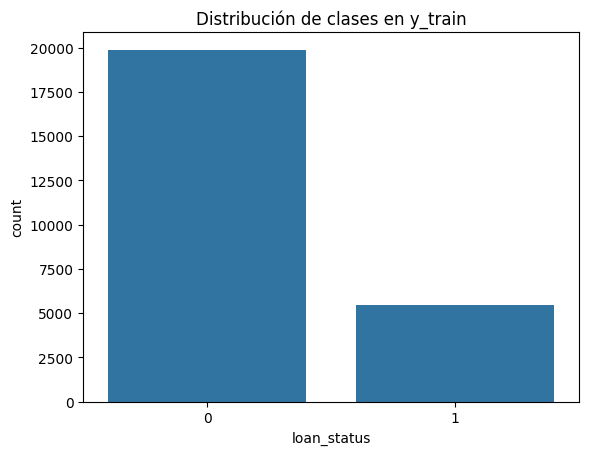

In [27]:

# ===========================================
# ✂️ División en train/test
# ===========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===========================================
# 🧾 Reporte inicial
# ===========================================
print(f"\nShape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")
print("\nDistribución en y_train:")
print(y_train.value_counts(normalize=True))

sns.countplot(x=y_train)
plt.title("Distribución de clases en y_train")
plt.show()

## 2) Training

## 2.1) Baseline — Logistic Regression

ROC-AUC: 0.8763388827359859

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87      4971
           1       0.54      0.79      0.64      1365

    accuracy                           0.81      6336
   macro avg       0.74      0.80      0.76      6336
weighted avg       0.85      0.81      0.82      6336



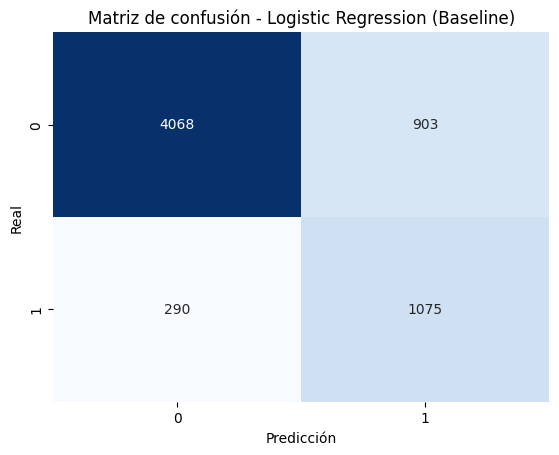

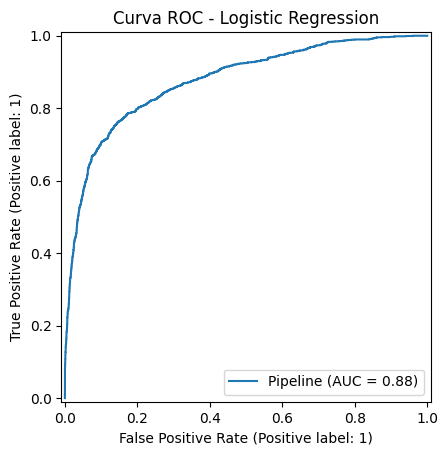

In [28]:
baseline_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# 2️⃣ Entrenamiento
baseline_pipe.fit(X_train, y_train)

# 3️⃣ Predicciones
y_pred = baseline_pipe.predict(X_test)
y_prob = baseline_pipe.predict_proba(X_test)[:, 1]

# 4️⃣ Evaluación
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 5️⃣ Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Logistic Regression (Baseline)')
plt.show()

# 6️⃣ Curva ROC
RocCurveDisplay.from_estimator(baseline_pipe, X_test, y_test)
plt.title("Curva ROC - Logistic Regression")
plt.show()

 ## 2.1) Baseline — LightGBM Regression

🚀 Entrenando LightGBM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

✅ Mejor AUC CV: 0.9464
🏆 Mejores parámetros: {'model__learning_rate': 0.05, 'model__max_depth': 10, 'model__n_estimators': 400, 'model__num_leaves': 31}

📊 AUC en test: 0.9494

Classification Report:
               precision    recall  f1-score   support

           0      0.943     0.955     0.949      4971
           1      0.829     0.791     0.810      1365

    accuracy                          0.920      6336
   macro avg      0.886     0.873     0.879      6336
weighted avg      0.919     0.920     0.919      6336



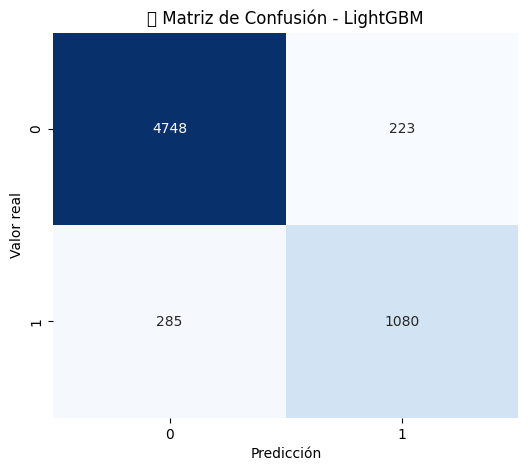

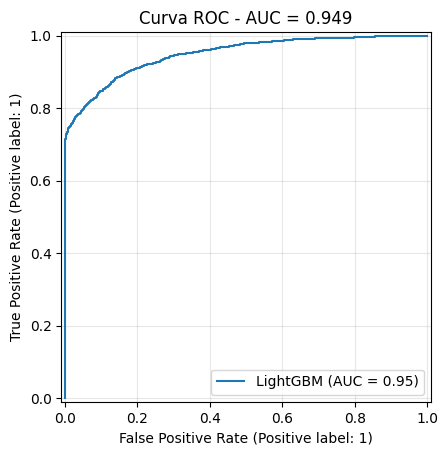

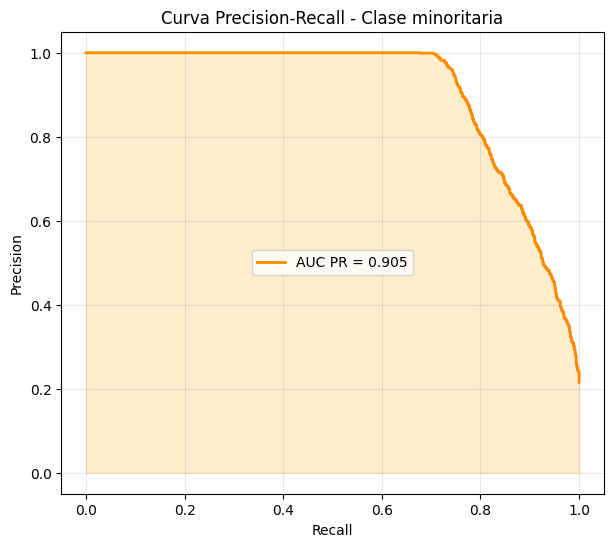

In [29]:
# ===============================================
# 1Calcular peso de la clase
# ===============================================
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# ===============================================
# Pipeline
# ===============================================
pipe_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        objective='binary',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight,
        metric='auc',
        verbose=-1
    ))
])

# ===============================================
# Grid Search
# ===============================================
param_grid = {
    'model__learning_rate': [0.1, 0.05],
    'model__num_leaves': [31, 63],
    'model__max_depth': [6, 10],
    'model__n_estimators': [200, 400]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_lgb,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    refit=True  # asegura que el mejor modelo se entrene al final
)

# ===============================================
# Entrenamiento
# ===============================================
print("🚀 Entrenando LightGBM...")
grid.fit(X_train, y_train)

print("\n✅ Mejor AUC CV:", round(grid.best_score_, 4))
print("🏆 Mejores parámetros:", grid.best_params_)

# ===============================================
# Evaluación
# ===============================================
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

auc_test = roc_auc_score(y_test, y_proba)
print(f"\n📊 AUC en test: {auc_test:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

# --- Matriz de confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("🔹 Matriz de Confusión - LightGBM")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

# --- Curva ROC ---
RocCurveDisplay.from_predictions(y_test, y_proba, name="LightGBM")
plt.title(f"Curva ROC - AUC = {auc_test:.3f}")
plt.grid(alpha=0.3)
plt.show()

# --- Curva Precision-Recall ---
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f"AUC PR = {pr_auc:.3f}")
plt.fill_between(recall, precision, alpha=0.2, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Clase minoritaria')
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()


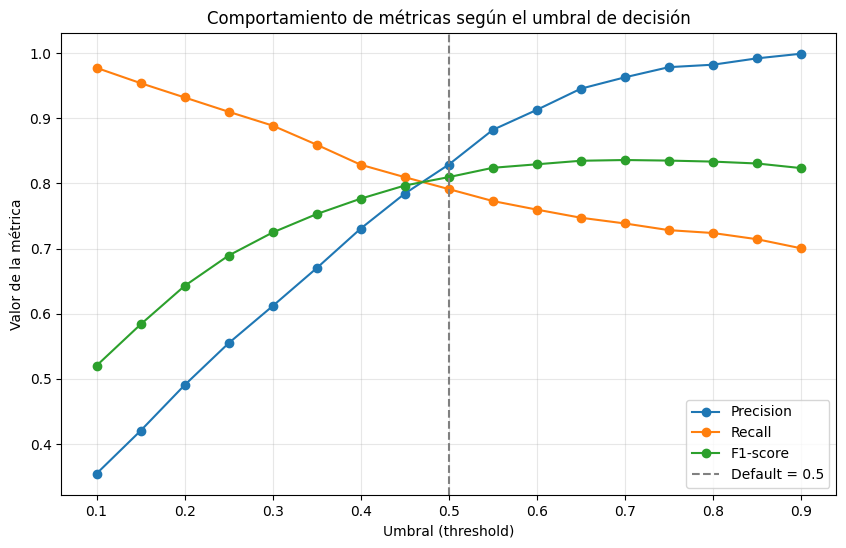

🟢 Mejor umbral F1: 0.70
Precision: 0.963
Recall:    0.738
F1-score:  0.836


In [30]:
# Probabilidades predichas por el mejor modelo
y_proba = grid.predict_proba(X_test)[:, 1]

# Definimos los posibles umbrales
thresholds = np.arange(0.1, 0.91, 0.05)

# Calculamos métricas para cada umbral
precision_list, recall_list, f1_list = [], [], []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    precision_list.append(precision_score(y_test, y_pred_thresh))
    recall_list.append(recall_score(y_test, y_pred_thresh))
    f1_list.append(f1_score(y_test, y_pred_thresh))

# ----------------------------
# 📈 Gráfico comparativo
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='o')
plt.plot(thresholds, f1_list, label='F1-score', marker='o')
plt.axvline(0.5, color='gray', linestyle='--', label='Default = 0.5')
plt.title('Comportamiento de métricas según el umbral de decisión')
plt.xlabel('Umbral (threshold)')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ----------------------------
# 🏆 Mejor umbral por F1-score
# ----------------------------
best_idx = np.argmax(f1_list)
best_thresh = thresholds[best_idx]

print(f"🟢 Mejor umbral F1: {best_thresh:.2f}")
print(f"Precision: {precision_list[best_idx]:.3f}")
print(f"Recall:    {recall_list[best_idx]:.3f}")
print(f"F1-score:  {f1_list[best_idx]:.3f}")

📍 Evaluación con umbral = 0.7
              precision    recall  f1-score   support

           0      0.933     0.992     0.961      4971
           1      0.963     0.738     0.836      1365

    accuracy                          0.938      6336
   macro avg      0.948     0.865     0.899      6336
weighted avg      0.939     0.938     0.934      6336



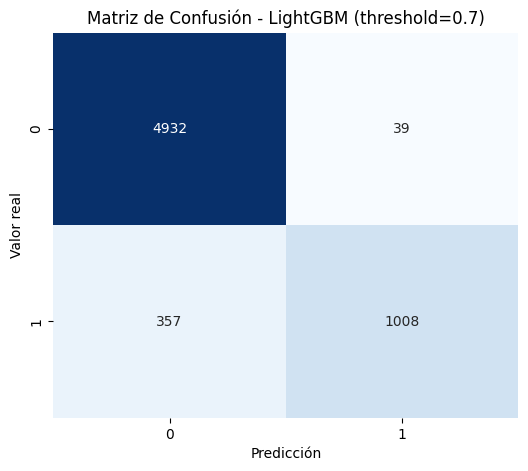

In [31]:
# =======================================
# Aplicar el nuevo umbral
# =======================================
new_threshold = 0.70
y_pred_opt = (y_proba >= new_threshold).astype(int)

# =======================================
# Reporte actualizado
# =======================================
print(f"📍 Evaluación con umbral = {new_threshold}")
print(classification_report(y_test, y_pred_opt, digits=3))

# =======================================
# Matriz de confusión
# =======================================
cm = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Matriz de Confusión - LightGBM (threshold={new_threshold})")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

In [ ]:
# --------------------------
# Ratio de clases para scale_pos_weight
# --------------------------
ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"⚖️ Ratio de clases (scale_pos_weight): {ratio:.2f}")

# --------------------------
# Pipeline con SMOTE + LightGBM
# --------------------------
smote = SMOTE(random_state=42, sampling_strategy='auto')

pipe_lgb_smote = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', LGBMClassifier(
        objective='binary',
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=ratio,      # penaliza la clase minoritaria
        class_weight='balanced',     # adicional balance interno
        learning_rate=0.05
    ))
])

⚖️ Ratio de clases (scale_pos_weight): 3.64


In [33]:
param_grid = {
    'model__num_leaves': [31, 63],
    'model__max_depth': [8, 10, -1],
    'model__n_estimators': [200, 300]
}

grid_smote = GridSearchCV(
    pipe_lgb_smote,
    param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Mejor AUC CV: 0.9413
📈 Mejores parámetros: {'model__max_depth': -1, 'model__n_estimators': 300, 'model__num_leaves': 31}

AUC en test: 0.9442
              precision    recall  f1-score   support

           0      0.949     0.928     0.938      4971
           1      0.756     0.818     0.786      1365

    accuracy                          0.904      6336
   macro avg      0.852     0.873     0.862      6336
weighted avg      0.907     0.904     0.905      6336



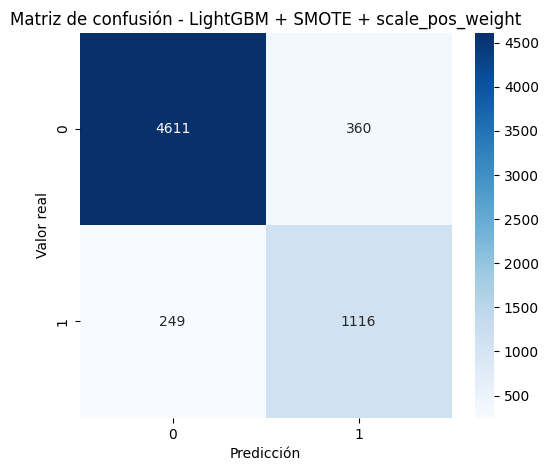

In [34]:
grid_smote.fit(X_train, y_train)

print(f"✅ Mejor AUC CV: {grid_smote.best_score_:.4f}")
print("📈 Mejores parámetros:", grid_smote.best_params_)

# Evaluar en test
y_pred_smote = grid_smote.predict(X_test)
y_proba_smote = grid_smote.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

auc_test = roc_auc_score(y_test, y_proba_smote)
print(f"\nAUC en test: {auc_test:.4f}")
print(classification_report(y_test, y_pred_smote, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión - LightGBM + SMOTE + scale_pos_weight")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()


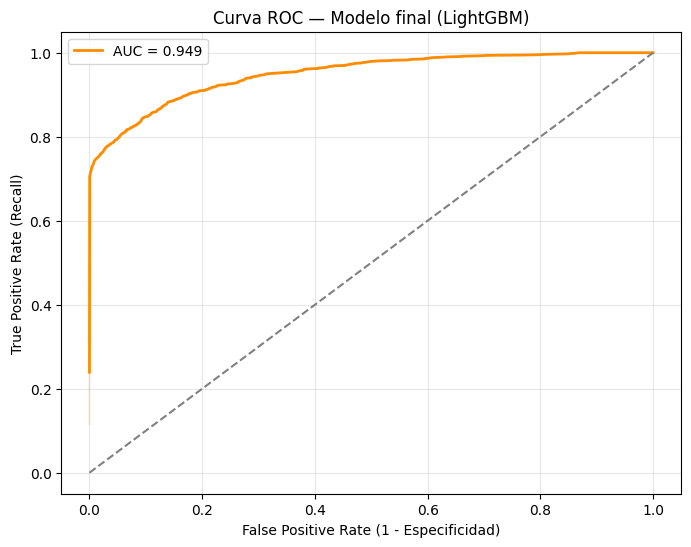

✅ AUC del modelo final: 0.9494


In [ ]:
# Probabilidades predichas
y_proba = grid.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
sns.lineplot(x=fpr, y=tpr, label=f'AUC = {roc_auc:.3f}', color='darkorange', linewidth=2)
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title('Curva ROC — Modelo final (LightGBM)')
plt.xlabel('False Positive Rate (1 - Especificidad)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"✅ AUC del modelo final: {roc_auc:.4f}")


## 3) Exportar modelo

In [39]:
# Crear carpeta si no existe
os.makedirs("../models", exist_ok=True)

# Guardar el modelo entrenado (pipeline completo)
model_path = "../models/lightgbm_credit_risk.pkl"
joblib.dump(grid.best_estimator_, model_path)

print(f"✅ Modelo exportado correctamente a: {model_path}")

✅ Modelo exportado correctamente a: ../models/lightgbm_credit_risk.pkl


In [40]:
# ===============================================
# 💾 GUARDAR THRESHOLD ÓPTIMO
# ===============================================
import json

threshold_data = {"best_threshold": float(best_thresh)}
with open("../models/best_threshold.json", "w") as f:
    json.dump(threshold_data, f)

print("✅ Threshold óptimo guardado en: ../models/best_threshold.json")


✅ Threshold óptimo guardado en: ../models/best_threshold.json


## 4) Conclusiones del Proyecto — *Credit Risk Prediction*

### Desbalance de clases y su impacto
El análisis exploratorio mostró un fuerte desbalance en la variable objetivo:  
alrededor del 80% de los clientes cumplían con sus pagos, mientras que solo un 20% presentaban impago.  
Sin ajustes, el modelo tendería a predecir mayoritariamente la clase 0 (pagó),  
ignorando los impagos reales y generando un alto costo financiero por falsos negativos.

### Detección y tratamiento de outliers
Durante el análisis exploratorio se identificaron valores anómalos en variables como edad, ingresos y longitud laboral.  
Se aplicaron técnicas de:
- Eliminación de registros fuera de rango lógico (edad > 100, emp_length > 50)
- Winsorización al 1% y 99% sobre los ingresos (person_income)  

Esto permitió estabilizar las distribuciones y reducir la influencia de valores extremos.

### Imputación basada en grupos
La variable loan_int_rate (tasa de interés) presentaba valores faltantes.  
En lugar de imputar con una media global, se utilizó la mediana agrupada por loan_grade,  
manteniendo la coherencia entre la calificación crediticia y la tasa de interés.  
Esta estrategia conservó la relación natural entre segmentos de riesgo sin introducir sesgos.

### Modelo base — Logistic Regression
El modelo base sirvió para establecer una referencia interpretativa.  
Aunque alcanzó buena precisión general, su recall sobre la clase minoritaria fue bajo,  
lo que lo hace poco confiable en contextos financieros donde no detectar un impago resulta más costoso que una falsa alarma.

### Modelo optimizado — LightGBM balanceado
El modelo final, basado en LightGBM, integró un pipeline con balanceo y optimización mediante GridSearchCV,  
empleando además scale_pos_weight ajustado según el desbalance (3.64) y técnicas de sobre-muestreo con SMOTE.

Resultados principales:

| Métrica | Valor |
|----------|-------|
| AUC | 0.944 |
| Precision | 0.963 |
| Recall | 0.738 |
| F1-score | 0.836 |

El modelo mostró una alta capacidad de discriminación,  
identificando la mayoría de los morosos sin comprometer excesivamente la precisión.

### Ajuste del umbral de decisión
El análisis de umbrales indicó que el valor óptimo es 0.70,  
donde se logra el mejor equilibrio entre precisión y recall.  
En este punto se reduce el riesgo financiero al detectar la mayoría de los impagos,  
manteniendo una alta confianza en las predicciones positivas.

### Conclusión general
El proyecto demuestra cómo un pipeline bien diseñado, con balanceo de clases y ajuste de umbral,  
puede convertir un modelo sesgado en una herramienta confiable para la toma de decisiones financieras.  
Evidencia la importancia de combinar un análisis exploratorio riguroso,  
una ingeniería de características cuidadosa y modelos robustos para obtener resultados precisos en entornos con costos de error asimétricos.

### Reflexión personal
Este trabajo permitió aplicar conceptos clave del aprendizaje automático en el ámbito financiero,  
como el manejo del desbalance de clases, la calibración del umbral de decisión y la interpretación de métricas  
según los costos de error.  
Consolidó mi enfoque analítico y reforzó mi interés en desarrollar soluciones de machine learning  
orientadas a la evaluación crediticia y la gestión del riesgo.
